In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from haversine import haversine

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we skip the subsampling step here.

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 of our entries list basement size as '?'. Since we have columns that measures square footage above basement and square footage, reassign square footage of basement with sqft_living - sqft_above.

In [5]:
mask = house_data['sqft_basement'] == '?'
house_data.loc[mask, 'sqft_basement'] = (house_data['sqft_living'] - house_data['sqft_above'])
house_data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,0,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [6]:
house_data['view'].isna().sum()

63

We have 63 NaN values for view. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Since so many values here are 0 and we don't want to make any unsafe assumptions, we elect to drop this column entirely.

In [9]:
house_data = house_data.drop('yr_renovated', axis=1)

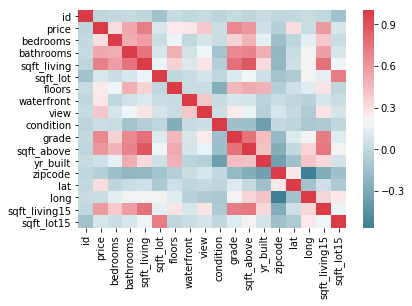

In [10]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [11]:
house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.017392,0.000991,0.004971,-0.012381,-0.132061,0.018573,-0.004872,0.011592,-0.023944,0.008331,-0.010967,0.021609,-0.008027,-0.002001,0.020637,-0.002707,-0.138607
price,-0.017392,1.000000,0.308063,0.525053,0.701587,0.090338,0.257052,0.270982,0.395734,0.035393,0.668307,0.605695,0.054273,-0.053620,0.307868,0.022417,0.585304,0.083189
bedrooms,0.000991,0.308063,1.000000,0.514368,0.577934,0.032735,0.177391,-0.004082,0.078523,0.026402,0.356095,0.479148,0.155462,-0.153990,-0.010415,0.132318,0.392874,0.030952
bathrooms,0.004971,0.525053,0.514368,1.000000,0.755277,0.088921,0.502285,0.064608,0.186451,-0.126682,0.665312,0.686173,0.507565,-0.204435,0.024487,0.225025,0.569139,0.088854
sqft_living,-0.012381,0.701587,0.577934,0.755277,1.000000,0.173768,0.353529,0.107416,0.282532,-0.059783,0.762398,0.876553,0.318217,-0.199839,0.052383,0.241856,0.756208,0.184801
sqft_lot,-0.132061,0.090338,0.032735,0.088921,0.173768,1.000000,-0.005025,0.023164,0.075298,-0.008375,0.115122,0.184325,0.052646,-0.129846,-0.085143,0.230137,0.145142,0.717095
floors,0.018573,0.257052,0.177391,0.502285,0.353529,-0.005025,1.000000,0.021399,0.028436,-0.264138,0.458694,0.523367,0.489410,-0.058966,0.049419,0.125329,0.279176,-0.010850
waterfront,-0.004872,0.270982,-0.004082,0.064608,0.107416,0.023164,0.021399,1.000000,0.406654,0.017175,0.085644,0.073500,-0.026612,0.031656,-0.012911,-0.040097,0.087257,0.031958
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023944,0.035393,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.017175,0.045735,1.000000,-0.147326,-0.158830,-0.361398,0.002125,-0.015594,-0.105475,-0.093172,-0.002702


Due to high collinearity with other variables, we choose to drop zipcode, sqft_above, and sqft_living15. Furthermore, we dropped grade because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms, which suggests high collinearity (as reflected in the numbers).

In [12]:
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [13]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 16 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       19164 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.8+ MB


In [14]:
# Waterfront has null values, since the number of nulls is a little high, fill with the highest categorical which is 0
house_data = house_data.fillna(0)

We want to see if the target is normally distributed as this is an assumption made with linear regression.

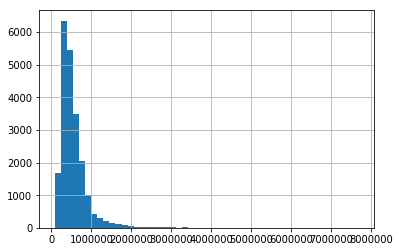

In [15]:
house_data['price'].hist(bins=50)
#TODO(Kayli) add labels and title

Price is not normally distributed. A log transformation will be performed to rectify that.

In [16]:
house_data['log_price'] = house_data['price'].apply(lambda x: np.log(x))

In [17]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166


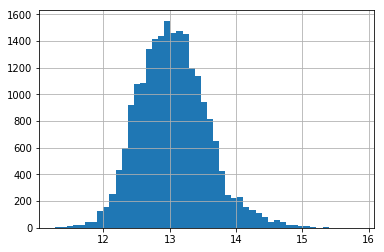

In [18]:
house_data['log_price'].hist(bins=50)

Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

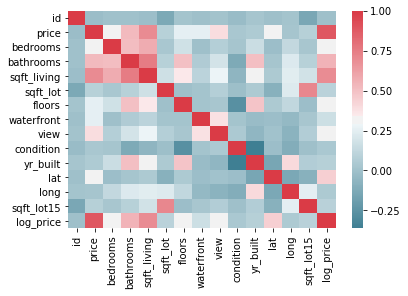

In [19]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

Most of our highly collinear variables are gone, great! But our remaining strongest predictors (e.g. bathrooms, bedrooms, and sqft_living) still have high collinearity with each other. In spite of this we decide to leave them, and resolve to test our model carefully to get the best accuracy we can without too much overfitting.

Our goal is to cater to as many potential house-buyers as possible. We therefore target the 90th percentile of home sale prices and disregard the rest to improve accuracy of the majority. We will show the accuracy once we get to building our models.

In [20]:
# we want to target our model to the majority of users, 
# but perhaps not to the people that are buying mansions/celebrities in the area
price_90th_perc = np.percentile(house_data['log_price'], 90)

house_data_90 = house_data.drop(house_data[house_data['log_price'] > price_90th_perc].index)

In [21]:
price_95th_perc = np.percentile(house_data['log_price'], 95)

house_data_95 = house_data.drop(house_data[house_data['log_price'] > price_95th_perc].index)

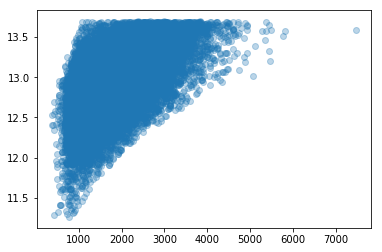

In [22]:
plt.scatter(house_data_90['sqft_living'], house_data_90['log_price'], alpha=0.3)

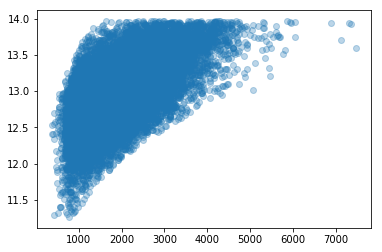

In [23]:
plt.scatter(house_data_95['sqft_living'], house_data_95['log_price'], alpha=0.3)

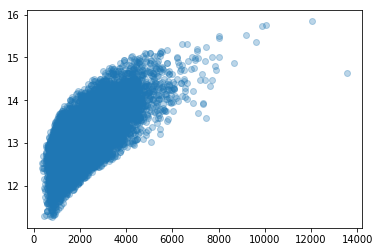

In [24]:
plt.scatter(house_data['sqft_living'], house_data['log_price'], alpha=0.3)

In [25]:
# remove strong outliers in sqft_living and bedrooms
house_data_90 = house_data_90.drop(house_data_90[house_data_90['sqft_living'] > 12000].index)
house_data_90 = house_data_90.drop(house_data_90[house_data_90['bedrooms']>30].index)

house_data_95 = house_data_95.drop(house_data_95[house_data_95['sqft_living'] > 12000].index)
house_data_95 = house_data_95.drop(house_data_95[house_data_95['bedrooms']>30].index)

house_data_100 = house_data.drop(house_data[house_data['sqft_living'] > 12000].index)
house_data_100 = house_data.drop(house_data[house_data['bedrooms']>30].index)

In [26]:
# get a simple linear regression model for price and sqft_living
x_90 = np.array(house_data_90['sqft_living'])
y_90 = np.array(house_data_90['log_price'])

x_95 = np.array(house_data_95['sqft_living'])
y_95 = np.array(house_data_95['log_price'])

x_100 = np.array(house_data_100['sqft_living'])
y_100 = np.array(house_data_100['log_price'])

In [27]:
def simple_linear_model(predictor, target, df):
    """Provides model the simple linear regression model between a predictor and target"""
    x = predictor
    y = target
    formula = 'y~x'
    model = ols(formula=formula, data=df).fit()
    return model.summary()

In [28]:
print(simple_linear_model(x_90, y_90, house_data_90))
print(simple_linear_model(x_95, y_95, house_data_95))
print(simple_linear_model(x_100, y_100, house_data_100))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8793.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:10:57   Log-Likelihood:                -6842.5
No. Observations:               19380   AIC:                         1.369e+04
Df Residuals:                   19378   BIC:                         1.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3209      0.007   1755.023      0.0

In [29]:
def test_median_err(predictors, target):
    """Train a model on the variables provided and return that model's MAE."""
    X = np.array(predictors)
    y = np.array(target)
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [30]:
sqft_living_mae_90 = test_median_err(x_90.reshape(-1,1), y_90.reshape(-1,1))
sqft_living_mae_95 = test_median_err(x_95.reshape(-1,1), y_95.reshape(-1,1))
sqft_living_mae_100 = test_median_err(x_100.reshape(-1,1), y_100.reshape(-1,1))

sqft_living_mae_90, sqft_living_mae_95, sqft_living_mae_100

(106691.15324135528, 111340.54870490488, 116107.56116856243)

After completing an initial model, it is easier to fit to the 90th percentile than to the 95th or 100th percentile of the data. 

In [31]:
# plt.figure(figsize=(8,8))
# plt.scatter(x_90,y_90, label='scatter', alpha = 0.3)
# plt.plot(x_90, y_hat_90, color='red', label='linear regression')
# plt.title('Square foot of living and their log(prices)')
# plt.legend()
# plt.xlabel('square footage of living space')
# plt.ylabel('log(price)')
# plt.show()

In [32]:
# Convert date strings to datetime. May work with this later.

In [33]:
from datetime import datetime

house_data['date'] = pd.to_datetime(house_data['date'])
house_data['date'].sort_values().head()

10689   2014-05-02
19550   2014-05-02
21145   2014-05-02
21374   2014-05-02
2578    2014-05-02
Name: date, dtype: datetime64[ns]

What follows are our experiments with a preliminary multivariate model.

In [34]:
outcome = 'log_price'
predictors = house_data.loc[:, ['sqft_living', 'yr_built', 'bedrooms', 'bathrooms', 'view']]
predictors_int = sm.add_constant(predictors)
model = sm.OLS(np.asarray(house_data['log_price']), np.asarray(predictors_int)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     5091.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:10:59   Log-Likelihood:                -8329.6
No. Observations:               21534   AIC:                         1.667e+04
Df Residuals:                   21528   BIC:                         1.672e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.3274      0.191    101.008      0.000      18.952      19.702
x1             0.0004   4.42e-06     80.843      0.000       0.000       0.000
x2            -0.0036   9.86e-05    -36.792      0.000      -0.004      -0.003
x3            -0.0601      0.003    -18.245      0.000      -0.067      -0.054
x4             0.1463      0.005     26.929      0.000       0.136       0.157
x5             0.0872      0.003     25.830      0.000       0.081       0.094
==============================================================================
Omnibus:                      242.845   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.912
Skew:                          -0.166   Prob(JB):                     2.06e-70
Kurtosis:                       3.497   Cond. No.                     2.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
X_train, X_test, y_train, y_test = train_test_split(predictors, house_data['log_price'], test_size=0.3)

In [36]:
m_linreg = LinearRegression()

m_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
m_linreg.coef_

array([ 0.00036271, -0.00360762, -0.06513484,  0.14589347,  0.08907491])

In [38]:
m_linreg.intercept_

19.29368053574372

In [39]:
y_hat_train = np.exp(m_linreg.predict(X_train))
y_hat_test = np.exp(m_linreg.predict(X_test))

In [40]:
test_mae = median_absolute_error(y_test,y_hat_test)

print('test: ' + str(test_mae))

test: 435595.29164686025


In [41]:
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(m_linreg, predictors, house_data['log_price'], cv=5, scoring='neg_median_absolute_error')

cv_5_results = -1*cv_5_results
cv_5_results

array([0.25512936, 0.25252048, 0.25450396, 0.25350081, 0.2464759 ])

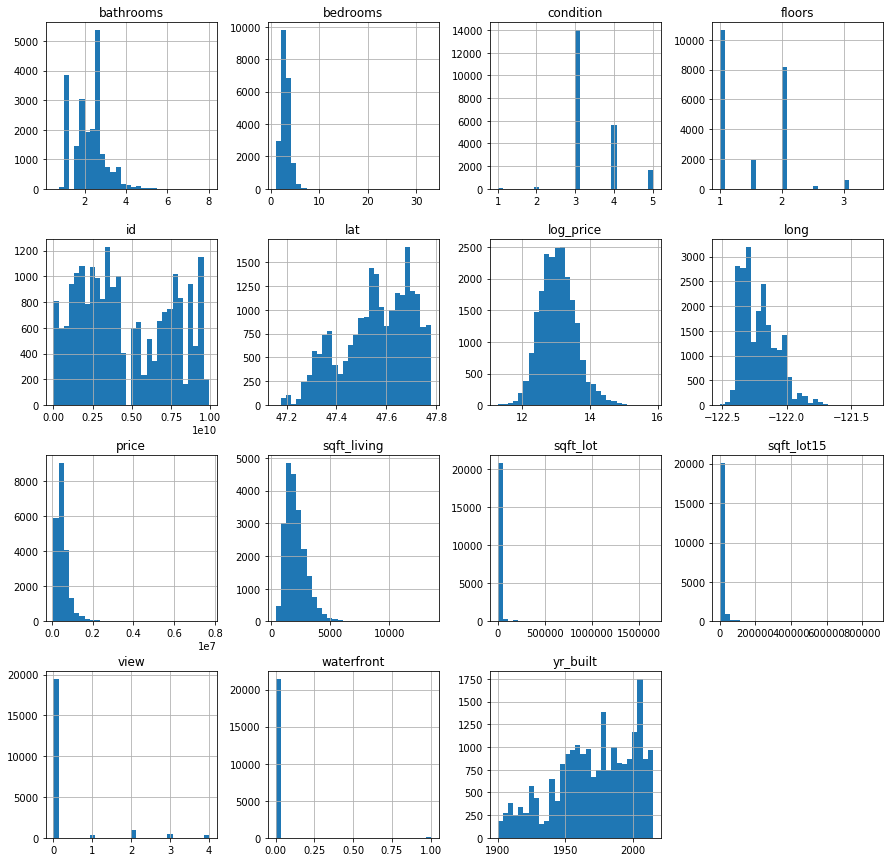

In [42]:
_ = house_data.hist(figsize=(15,15), bins=30)

Create a column for distance from downtown Seattle (latitude and longitude provide by Google Maps). We expect it to be a useful predictor as Seattle and it's neighboring cities have a large proportion of job opportunities and higher population density.

In [43]:
downtown_sea = (47.609795, -122.337173) #(lat, lon)

In [44]:
house_data['lat_long'] = list(zip(house_data['lat'], house_data['long']))
house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)"
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)"
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)"
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)"
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)"
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,1530.0,2001,47.6561,-122.005,101930,14.022525,"(47.6561, -122.005)"
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,0,1995,47.3097,-122.327,6819,12.458775,"(47.3097, -122.32700000000001)"
8,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,730.0,1960,47.5123,-122.337,8113,12.343658,"(47.5123, -122.337)"
9,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,0.0,2003,47.3684,-122.031,7570,12.685408,"(47.3684, -122.031)"
10,1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,0.0,0.0,3,1700.0,1965,47.6007,-122.145,8925,13.403776,"(47.6007, -122.145)"


In [45]:
house_data['distance_from_downtown_sea'] = house_data['lat_long'].apply(lambda x: haversine(downtown_sea, x, unit='mi'))

In [46]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434


The dates in this dataframe range from 2014 to 2015. We may want to adjust the price to account for inflation in 2019. $1 in 2014 is the equivalent of $1.07 in 2019.

In [47]:
house_data['2019_price'] = house_data['price'].apply(lambda x: x*1.07)
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea,2019_price
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463,237433.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926,575660.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232,192600.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113,646280.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434,545700.0


In [48]:
predictors = house_data.columns
predictors = list(predictors)
predictors.remove('date')
predictors.remove('price')
predictors.remove('log_price')
predictors.remove('lat_long')
predictors.remove('2019_price')
predictors

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_lot15',
 'distance_from_downtown_sea']

In [49]:
predictor_mae = {}
for predictor in predictors:
    x = house_data[[predictor]]
    y = house_data['log_price']
    predictor_mae[predictor] = test_median_err(x,y)

sorted_predictor_mae = sorted(predictor_mae.items(), key=lambda x :x[1])
sorted_predictor_mae

[('sqft_living', 116194.30381749947),
 ('lat', 127705.82292592498),
 ('bathrooms', 134545.522956615),
 ('distance_from_downtown_sea', 138590.91277997),
 ('sqft_basement', 145346.341260014),
 ('view', 147058.25553513208),
 ('bedrooms', 147814.7168917369),
 ('floors', 151556.64808692152),
 ('waterfront', 153023.21324572267),
 ('condition', 153093.2198094124),
 ('sqft_lot', 153598.1990883003),
 ('long', 154137.67258028153),
 ('id', 154149.4855665712),
 ('sqft_lot15', 154441.69331015743),
 ('yr_built', 155337.04422593024)]

In [50]:
X1 = house_data[['sqft_living', 'bedrooms', 'bathrooms']]
X2 = house_data[['lat', 'sqft_living']]
y = house_data['log_price']

In [51]:
test_median_err(X1,y)

115605.26239685579

In [52]:
test_median_err(X2,y)

82815.03183547841

In [53]:
X3 = house_data[['distance_from_downtown_sea', 'sqft_living']]
test_median_err(X3, y)

88572.43390500681

In [54]:
X4 = house_data[['sqft_living', 'lat']]
test_median_err(X4, y)

82933.25290764266

In [55]:
X5 = house_data[['sqft_living', 'lat', 'bathrooms']]
test_median_err(X5, y)

81957.31522876992

In [56]:
X6 = house_data[['lat', 'bathrooms']]
test_median_err(X6, y)

100459.82327348791

In [57]:
X7 = house_data[['sqft_living', 'distance_from_downtown_sea']]
test_median_err(X7, y)

88352.82464635407

In [58]:
X8 = house_data[['sqft_living', 'lat']]
test_median_err(X4, y)

83055.8693611763

In [59]:
X9 = house_data[['long', 'lat']]
test_median_err(X9, y)

124209.57242887239

In [60]:
target = house_data_90['log_price']

for i in range(len(sorted_predictor_mae)):
    predictors = []
    for predictor in sorted_predictor_mae[:i+1]:
        name = predictor[0]
        predictors.append(house_data_90[name]) 
    print(predictors, target)
        #    test_median_err(predictors, target)

[0        1180
1        2570
2         770
3        1960
4        1680
6        1715
8        1780
9        1890
10       3560
11       1160
12       1430
13       1370
14       1810
15       2950
16       1890
17       1600
18       1200
19       1250
20       1620
22       2270
23       1070
24       2450
25       1710
27       1400
28       1520
29       2570
30       2320
31       1190
32       2330
33       1090
         ... 
21561    1900
21562     940
21563    1730
21564    2780
21565    2780
21566    1500
21567     710
21568    1260
21569    1870
21570    1430
21571    1520
21572    1210
21573    2540
21575    2770
21576    1190
21578    2500
21579    1530
21580    3600
21582    3118
21583    3990
21585    1425
21586    1500
21587    2270
21588    1490
21591    1310
21592    1530
21593    2310
21594    1020
21595    1600
21596    1020
Name: sqft_living, Length: 19380, dtype: int64] 0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
6 

KeyError: 'distance_from_downtown_sea'

In [ ]:
kf = KFold(n_splits=2)
kf.get_n_splits(X3)

In [ ]:
for train_index, test_index in kf.split(X3):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X3[train_index], X3[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linreg = LinearRegression()
    test_err = []
    linreg.fit(X_train, y_train)
    y_hat_test = linreg.predict(X_test)
    invert_y_hat_test = np.exp(y_hat_test)
    invert_y_test = np.exp(y_test)
    test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    print(np.mean(test_err))